# Impact of Adversarial Attacks on Customer Churn Prediction Models

In [1]:
#Import needed libraries
import numpy as np
import pandas as pd
np.random.seed(5) # for reproducibility
from pandas import read_csv
from numpy import array
from numpy import argmax
from collections import Counter

#Libraries for preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Libraries for feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2
from sklearn.feature_selection import mutual_info_classif

#Libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Dense, Dropout, Activation
from art.estimators.classification import SklearnClassifier,KerasClassifier

# Libraries for metrics
from sklearn import metrics
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

# Libraries for attacks
from art.attacks.evasion import SaliencyMapMethod
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import DeepFool
from art.estimators.classification import SklearnClassifier

# Libraries for visualisation
### pip install scikit-plot   ---> remove hash and run to install if uninstalled
import scikitplot as skplt
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline



import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

Populating the interactive namespace from numpy and matplotlib


## 1.0 Dataset loading and exploration

In [2]:
data=pd.read_csv('Customer_Churn.csv')
print("Dataset: {}".format(data.shape))
print("Columns: {}".format(data.columns))
data.head(5)

Dataset: (7043, 21)
Columns: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Check missing values
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
data.drop(['customerID'], axis=1, inplace=True)

In [5]:
columns_to_convert = ['Partner', 
                      'Dependents', 
                      'PhoneService', 
                      'PaperlessBilling', 
                      'Churn']

for item in columns_to_convert:
    data[item].replace(to_replace='Yes', value=1, inplace=True)
    data[item].replace(to_replace='No',  value=0, inplace=True)
data.head()

data['gender'].replace(to_replace='Female', value=1, inplace=True)
data['gender'].replace(to_replace='Male', value=1, inplace=True)

In [6]:
data['TotalCharges'] = data['TotalCharges'].replace(r'\s+', np.nan, regex=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

df = pd.get_dummies(data)
df.fillna(value=0, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


In [7]:
target=df['Churn']
features= df.drop(columns=['Churn'])

In [8]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()

# transform data
df_scaled = scaler.fit_transform(df)
df_scaled.max()

1.0

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(features, target)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 5174, 1: 5174})


In [11]:
def one_hot_encode(data):
    label_encoder = LabelEncoder()
    target_int = label_encoder.fit_transform(data)
    onehot_encoder = OneHotEncoder(sparse=False)
    target_int = target_int.reshape(len(target_int), 1)
    data_onehot = onehot_encoder.fit_transform(target_int)
    return data_onehot

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_res, y_res,test_size=0.2, random_state=9)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (8278, 40) (8278,)
Test set: (2070, 40) (2070,)


In [13]:
y_train_onehot= one_hot_encode(y_train)
y_test_onehot= one_hot_encode(y_test)

# Modelling

In [14]:
target_names= ['non-churn', 'churn' ]

### LOGISTIC REGRESSION

In [15]:
### Logistic regression Model
lr_model_base=LogisticRegression(max_iter=10000).fit(X_train, y_train)
ypred = lr_model_base.predict(X_test)
yprob=lr_model_base.predict_proba(X_test)
print(classification_report(y_test, ypred, target_names=target_names))

              precision    recall  f1-score   support

   non-churn       0.86      0.84      0.85      1052
       churn       0.84      0.86      0.85      1018

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070



In [16]:
sns.color_palette("rocket", as_cmap=True)
sns.set(font_scale=1.4)
plt.style.use('seaborn-darkgrid')

[[880 172]
 [146 872]]


Text(50.5, 0.5, 'True Class')

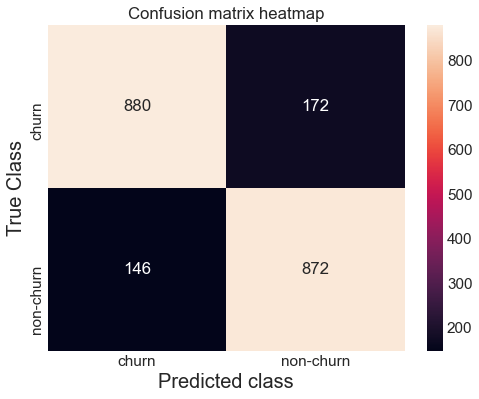

In [17]:
cf_matrix=confusion_matrix(y_test, ypred)
print(cf_matrix)

plt.figure(figsize = (8, 6))
sns.heatmap(cf_matrix, annot=True, cmap='rocket', fmt='g', xticklabels=['churn','non-churn'], yticklabels=['churn' ,'non-churn'])
plt.title("Confusion matrix heatmap")
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("True Class", fontsize=20)

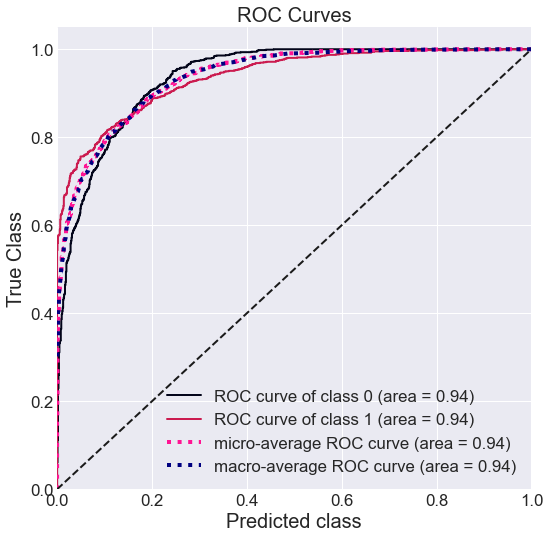

In [18]:
pylab.rcParams['figure.figsize'] = (8.5, 8.5)
skplt.metrics.plot_roc(y_test,yprob,cmap="rocket")
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("True Class", fontsize=20)
plt.show() 

### SUPPORT VECTOR CLASSIFIER

In [19]:
svc_model_base=SVC(probability=True,kernel='rbf',gamma=0.001, C=1).fit(X_train, y_train)
ypred = svc_model_base.predict(X_test)
yprob=svc_model_base.predict_proba(X_test)
print(classification_report(y_test, ypred, target_names=target_names))

              precision    recall  f1-score   support

   non-churn       0.83      0.70      0.76      1052
       churn       0.73      0.85      0.79      1018

    accuracy                           0.77      2070
   macro avg       0.78      0.77      0.77      2070
weighted avg       0.78      0.77      0.77      2070



Text(50.5, 0.5, 'True Class')

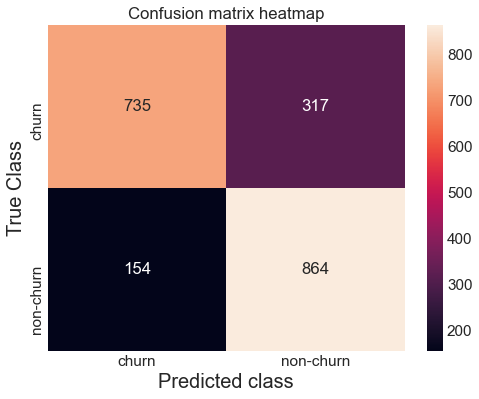

In [20]:
cf_matrix=confusion_matrix(y_test, ypred)
plt.figure(figsize = (8, 6))
sns.heatmap(cf_matrix, annot=True, cmap='rocket', fmt='g', xticklabels=['churn','non-churn'], yticklabels=['churn' ,'non-churn'])
plt.title("Confusion matrix heatmap")
plt.xlabel("Predicted class", fontsize=20)
plt.ylabel("True Class", fontsize=20)


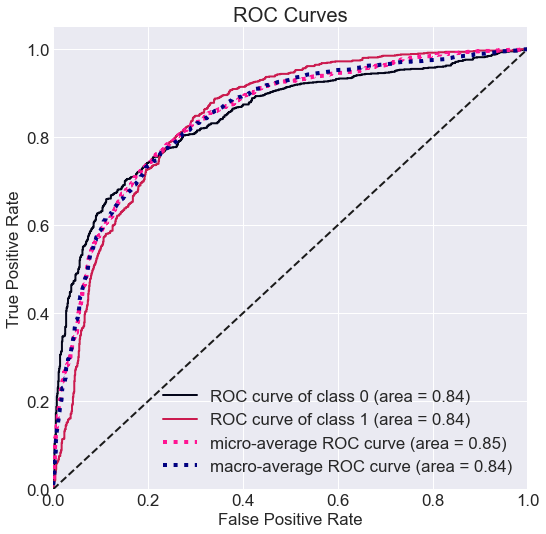

In [21]:
skplt.metrics.plot_roc(y_test,yprob, cmap="rocket")
plt.show() 

### ANN

In [22]:
PYTHONHASHSEED=0
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures
import random as python_random

python_random.seed(123)

tf.random.set_seed(1234)

ann_model_base = keras.Sequential(
    [
        keras.layers.Dense(100, input_shape=(X_train.shape[1],), activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(100, activation="relu",),
        keras.layers.Dense(2, activation="softmax"),
    ]
)

ann_model_base.compile(optimizer ='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

ann_model_base.fit(X_train,y_train_onehot, epochs=30, verbose=False)

In [23]:


yprob=ann_model_base.predict(X_test)
ypred = np.argmax(yprob, axis=1)
y_test = np.argmax(y_test_onehot, axis=1)

print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79      1052
           1       0.76      0.88      0.82      1018

    accuracy                           0.80      2070
   macro avg       0.81      0.81      0.80      2070
weighted avg       0.81      0.80      0.80      2070



Text(50.5, 0.5, 'True Class')

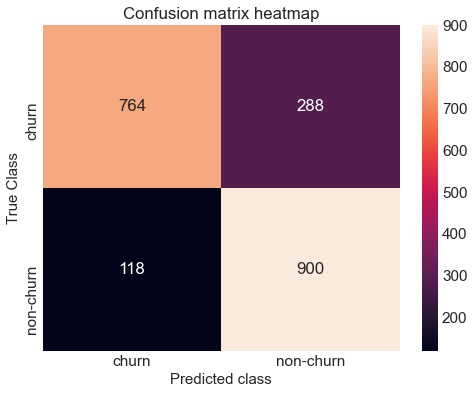

In [24]:
cf_matrix=confusion_matrix(y_test, ypred)
plt.figure(figsize = (8, 6))
sns.heatmap(cf_matrix, annot=True, cmap='rocket', fmt='g', xticklabels=['churn','non-churn'], yticklabels=['churn','non-churn'])
plt.title("Confusion matrix heatmap")
plt.xlabel("Predicted class", fontsize=15)
plt.ylabel("True Class", fontsize=15)


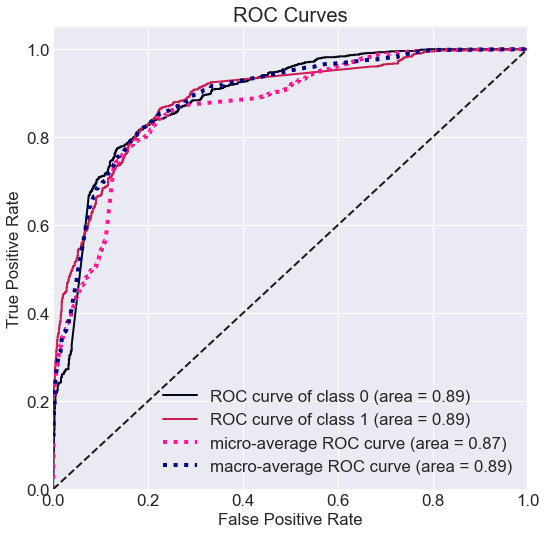

In [25]:
skplt.metrics.plot_roc(y_test,yprob,cmap="rocket")
plt.show()

# ATTACKS

## FSGM

In [26]:
results=[]

In [27]:
def fgsm_data(X_test,eps):
    lr_model=SklearnClassifier(model=lr_model_base)
    attack = FastGradientMethod(estimator=lr_model, eps=eps)
    new_x=attack.generate(x=X_test)
    return new_x

In [28]:
def evaluate(i, model, y_test,X_test):
    y_pred = model.predict(X_test)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred,pos_label=1 )*100)
    f1score= (f1_score(y_test, y_pred,pos_label=1 )*100)
    recall= (recall_score(y_test, y_pred,pos_label=1 )*100)
    return {'attack':"FSGM",'Model':"LR", 'epsilon' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}

In [29]:
epsilon=[0,0.1, 0.20, 0.3 ,0.4,0.5,0.6,0.7,0.8,0.9,1]
for i in epsilon:
    new_x=fgsm_data(X_test=X_test,eps=i)
    lr_eval_data=evaluate(i,lr_model_base, y_test , new_x)
    results.append(lr_eval_data)
fgsm_res=pd.DataFrame(results)
fgsm_res

,attack,Model,epsilon,accuracy,precision,f1score,recall
0,FSGM,LR,0.0,84.637681,83.524904,84.578080,85.658153
1,FSGM,LR,0.1,42.222222,42.764228,46.797153,51.669941
2,FSGM,LR,0.2,18.405797,19.191919,19.838633,20.530452
3,FSGM,LR,0.3,15.458937,14.396887,14.467253,14.538310
4,FSGM,LR,0.4,15.362319,14.230019,14.285714,14.341847
5,FSGM,LR,0.5,15.362319,14.230019,14.285714,14.341847
6,FSGM,LR,0.6,15.362319,14.230019,14.285714,14.341847
7,FSGM,LR,0.7,15.362319,14.230019,14.285714,14.341847
8,FSGM,LR,0.8,15.362319,14.230019,14.285714,14.341847
9,FSGM,LR,0.9,15.362319,14.230019,14.285714,14.341847


In [30]:
def evaluate(i, model, y_test,X_test):
    y_pred = model.predict(X_test)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred,pos_label=1 )*100)
    f1score= (f1_score(y_test, y_pred,pos_label=1 )*100)
    recall= (recall_score(y_test, y_pred,pos_label=1 )*100)
    return {'attack':"FSGM",'Model':"SVC", 'epsilon' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}

In [31]:

for i in epsilon:
    new_x= fgsm_data(X_test=X_test,eps=i)
    svc_eval_data=evaluate(i,svc_model_base, y_test , new_x)
    results.append(svc_eval_data)
fgsm_res=pd.DataFrame(results)
fgsm_res

,attack,Model,epsilon,accuracy,precision,f1score,recall
0,FSGM,LR,0.0,84.637681,83.524904,84.578080,85.658153
1,FSGM,LR,0.1,42.222222,42.764228,46.797153,51.669941
2,FSGM,LR,0.2,18.405797,19.191919,19.838633,20.530452
3,FSGM,LR,0.3,15.458937,14.396887,14.467253,14.538310
4,FSGM,LR,0.4,15.362319,14.230019,14.285714,14.341847
5,FSGM,LR,0.5,15.362319,14.230019,14.285714,14.341847
6,FSGM,LR,0.6,15.362319,14.230019,14.285714,14.341847
7,FSGM,LR,0.7,15.362319,14.230019,14.285714,14.341847
8,FSGM,LR,0.8,15.362319,14.230019,14.285714,14.341847
9,FSGM,LR,0.9,15.362319,14.230019,14.285714,14.341847


In [32]:
def evaluate(i, model, y_test,X_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred, pos_label=1 )*100)
    f1score= (f1_score(y_test, y_pred, pos_label=1 )*100)
    recall= (recall_score(y_test, y_pred, pos_label=1 )*100)
    return {'attack':"FSGM",'Model':"ANN", 'epsilon' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}


In [33]:
for i in epsilon:
    new_x= fgsm_data(X_test=X_test,eps=i)
    ann_eval_data=evaluate(i,ann_model_base, y_test, new_x)
    results.append(ann_eval_data)
fgsm_res=pd.DataFrame(results)
fgsm_res

,attack,Model,epsilon,accuracy,precision,f1score,recall
0,FSGM,LR,0.0,84.637681,83.524904,84.578080,85.658153
1,FSGM,LR,0.1,42.222222,42.764228,46.797153,51.669941
2,FSGM,LR,0.2,18.405797,19.191919,19.838633,20.530452
3,FSGM,LR,0.3,15.458937,14.396887,14.467253,14.538310
4,FSGM,LR,0.4,15.362319,14.230019,14.285714,14.341847
5,FSGM,LR,0.5,15.362319,14.230019,14.285714,14.341847
6,FSGM,LR,0.6,15.362319,14.230019,14.285714,14.341847
7,FSGM,LR,0.7,15.362319,14.230019,14.285714,14.341847
8,FSGM,LR,0.8,15.362319,14.230019,14.285714,14.341847
9,FSGM,LR,0.9,15.362319,14.230019,14.285714,14.341847


## Deep fool

In [34]:
results=[]

In [35]:
def deepfool_data(X_test,eps):
    lr_model=SklearnClassifier(model=lr_model_base)
    attack = DeepFool(classifier=lr_model, epsilon=eps)
    new_x=attack.generate(x=X_test)
    return new_x

In [36]:
def evaluate(i, model, y_test,X_test):
    y_pred = model.predict(X_test)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred,pos_label=1 )*100)
    f1score= (f1_score(y_test, y_pred,pos_label=1 )*100)
    recall= (recall_score(y_test, y_pred,pos_label=1 )*100)
    return {'attack':"deepfool",'Model':"LR", 'epsilon' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}

In [37]:
epsilon=[0,0.000001, 0.0000020, 0.000003 ,0.000004,0.000005,0.000006,0.000007,0.000008,0.000009,0.00001]
for i in epsilon:
    new_x=deepfool_data(X_test=X_test,eps=i)
    lr_eval_data=evaluate(i,lr_model_base, y_test , new_x)
    results.append(lr_eval_data)
deepfool_res=pd.DataFrame(results)
deepfool_res

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

,attack,Model,epsilon,accuracy,precision,f1score,recall
0,deepfool,LR,0.000000,15.314010,14.216164,14.278729,14.341847
1,deepfool,LR,0.000001,15.362319,14.230019,14.285714,14.341847
2,deepfool,LR,0.000002,15.362319,14.230019,14.285714,14.341847
3,deepfool,LR,0.000003,15.362319,14.230019,14.285714,14.341847
4,deepfool,LR,0.000004,15.362319,14.230019,14.285714,14.341847
5,deepfool,LR,0.000005,15.362319,14.230019,14.285714,14.341847
6,deepfool,LR,0.000006,15.362319,14.230019,14.285714,14.341847
7,deepfool,LR,0.000007,15.362319,14.230019,14.285714,14.341847
8,deepfool,LR,0.000008,15.362319,14.230019,14.285714,14.341847
9,deepfool,LR,0.000009,15.362319,14.230019,14.285714,14.341847


In [38]:
def evaluate(i, model, y_test,X_test):
    y_pred = model.predict(X_test)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred,pos_label=1 )*100)
    f1score= (f1_score(y_test, y_pred,pos_label=1 )*100)
    recall= (recall_score(y_test, y_pred,pos_label=1 )*100)
    return {'attack':"deepfool",'Model':"SVC", 'epsilon' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}

In [39]:
for i in epsilon:
    new_x= deepfool_data(X_test=X_test,eps=i)
    svc_eval_data=evaluate(i,svc_model_base, y_test , new_x)
    results.append(svc_eval_data)
deepfool_res=pd.DataFrame(results)
deepfool_res

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

,attack,Model,epsilon,accuracy,precision,f1score,recall
0,deepfool,LR,0.000000,15.314010,14.216164,14.278729,14.341847
1,deepfool,LR,0.000001,15.362319,14.230019,14.285714,14.341847
2,deepfool,LR,0.000002,15.362319,14.230019,14.285714,14.341847
3,deepfool,LR,0.000003,15.362319,14.230019,14.285714,14.341847
4,deepfool,LR,0.000004,15.362319,14.230019,14.285714,14.341847
5,deepfool,LR,0.000005,15.362319,14.230019,14.285714,14.341847
6,deepfool,LR,0.000006,15.362319,14.230019,14.285714,14.341847
7,deepfool,LR,0.000007,15.362319,14.230019,14.285714,14.341847
8,deepfool,LR,0.000008,15.362319,14.230019,14.285714,14.341847
9,deepfool,LR,0.000009,15.362319,14.230019,14.285714,14.341847


In [40]:
def evaluate(i, model, y_test,X_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred, pos_label=1 )*100)
    f1score= (f1_score(y_test, y_pred, pos_label=1 )*100)
    recall= (recall_score(y_test, y_pred, pos_label=1 )*100)
    return {'attack':"deepfool",'Model':"ANN", 'epsilon' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}


In [41]:
for i in epsilon:
    new_x= deepfool_data(X_test=X_test,eps=i)
    ann_eval_data=evaluate(i,ann_model_base, y_test, new_x)
    results.append(ann_eval_data)
deepfool_res=pd.DataFrame(results)
deepfool_res

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/2070 [00:00<?, ?it/s]

,attack,Model,epsilon,accuracy,precision,f1score,recall
0,deepfool,LR,0.000000,15.314010,14.216164,14.278729,14.341847
1,deepfool,LR,0.000001,15.362319,14.230019,14.285714,14.341847
2,deepfool,LR,0.000002,15.362319,14.230019,14.285714,14.341847
3,deepfool,LR,0.000003,15.362319,14.230019,14.285714,14.341847
4,deepfool,LR,0.000004,15.362319,14.230019,14.285714,14.341847
5,deepfool,LR,0.000005,15.362319,14.230019,14.285714,14.341847
6,deepfool,LR,0.000006,15.362319,14.230019,14.285714,14.341847
7,deepfool,LR,0.000007,15.362319,14.230019,14.285714,14.341847
8,deepfool,LR,0.000008,15.362319,14.230019,14.285714,14.341847
9,deepfool,LR,0.000009,15.362319,14.230019,14.285714,14.341847


## JSMA

In [42]:
results=[]

In [43]:
def jsma_data(X_test,theta):
    lr_model=SklearnClassifier(model=lr_model_base)
    attack = SaliencyMapMethod(classifier=lr_model, theta=theta, gamma = 0.01)
    new_x=attack.generate(x=X_test)
    return new_x

In [44]:
def evaluate(i, model, y_test,X_test):
    y_pred = model.predict(X_test)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred,pos_label=1 )*100)
    f1score= (f1_score(y_test, y_pred,pos_label=1 )*100)
    recall= (recall_score(y_test, y_pred,pos_label=1 )*100)
    return {'attack':"JSMA",'Model':"LR", 'theta' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}

In [45]:
theta=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in theta:
    new_x=jsma_data(X_test=X_test,theta=i)
    lr_eval_data=evaluate(i,lr_model_base, y_test , new_x)
    results.append(lr_eval_data)
jsma_res=pd.DataFrame(results)
jsma_res

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

,attack,Model,theta,accuracy,precision,f1score,recall
0,JSMA,LR,0.1,84.637681,86.610879,83.890578,81.335953
1,JSMA,LR,0.2,82.318841,86.222222,80.917623,76.227898
2,JSMA,LR,0.3,75.314010,80.286738,72.452830,66.011788
3,JSMA,LR,0.4,71.062802,74.560375,67.985035,62.475442
4,JSMA,LR,0.5,68.599034,70.353982,66.181061,62.475442
5,JSMA,LR,0.6,64.589372,65.372168,62.313625,59.528487
6,JSMA,LR,0.7,60.724638,60.755509,58.751903,56.876228
7,JSMA,LR,0.8,56.956522,56.553148,55.158530,53.831041
8,JSMA,LR,0.9,53.236715,52.556237,51.503006,50.491159


In [46]:
def evaluate(i, model, y_test,X_test):
    y_pred = model.predict(X_test)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred,pos_label=1 )*100)
    f1score= (f1_score(y_test, y_pred,pos_label=1 )*100)
    recall= (recall_score(y_test, y_pred,pos_label=1 )*100)
    return {'attack':"JSMA",'Model':"SVC", 'theta' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}

In [47]:
theta=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in theta:
    new_x=jsma_data(X_test=X_test,theta=i)
    svc_eval_data=evaluate(i,svc_model_base, y_test , new_x)
    results.append(svc_eval_data)
jsma_res=pd.DataFrame(results)
jsma_res


JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

,attack,Model,theta,accuracy,precision,f1score,recall
0,JSMA,LR,0.1,84.637681,86.610879,83.890578,81.335953
1,JSMA,LR,0.2,82.318841,86.222222,80.917623,76.227898
2,JSMA,LR,0.3,75.314010,80.286738,72.452830,66.011788
3,JSMA,LR,0.4,71.062802,74.560375,67.985035,62.475442
4,JSMA,LR,0.5,68.599034,70.353982,66.181061,62.475442
5,JSMA,LR,0.6,64.589372,65.372168,62.313625,59.528487
6,JSMA,LR,0.7,60.724638,60.755509,58.751903,56.876228
7,JSMA,LR,0.8,56.956522,56.553148,55.158530,53.831041
8,JSMA,LR,0.9,53.236715,52.556237,51.503006,50.491159
9,JSMA,SVC,0.1,77.246377,73.158340,78.581173,84.872299


In [48]:
def evaluate(i, model, y_test,X_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy= (accuracy_score(y_test, y_pred )*100)
    precision= (precision_score(y_test, y_pred, pos_label=0 )*100)
    f1score= (f1_score(y_test, y_pred, pos_label=0 )*100)
    recall= (recall_score(y_test, y_pred, pos_label=0 )*100)
    return {'attack':"JSMA",'Model':"ANN", 'theta' : i  ,'accuracy': accuracy, 'precision':precision, 'f1score': f1score, 'recall': recall}

In [49]:
for i in theta:
    new_x= jsma_data(X_test=X_test,theta=i)
    ann_eval_data=evaluate(i,ann_model_base, y_test, new_x)
    results.append(ann_eval_data)
jsma_res=pd.DataFrame(results)
jsma_res

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

JSMA:   0%|          | 0/2070 [00:00<?, ?it/s]

,attack,Model,theta,accuracy,precision,f1score,recall
0,JSMA,LR,0.1,84.637681,86.610879,83.890578,81.335953
1,JSMA,LR,0.2,82.318841,86.222222,80.917623,76.227898
2,JSMA,LR,0.3,75.314010,80.286738,72.452830,66.011788
3,JSMA,LR,0.4,71.062802,74.560375,67.985035,62.475442
4,JSMA,LR,0.5,68.599034,70.353982,66.181061,62.475442
5,JSMA,LR,0.6,64.589372,65.372168,62.313625,59.528487
6,JSMA,LR,0.7,60.724638,60.755509,58.751903,56.876228
7,JSMA,LR,0.8,56.956522,56.553148,55.158530,53.831041
8,JSMA,LR,0.9,53.236715,52.556237,51.503006,50.491159
9,JSMA,SVC,0.1,77.246377,73.158340,78.581173,84.872299


In [50]:
fgsm_res.head()

,attack,Model,epsilon,accuracy,precision,f1score,recall
0,FSGM,LR,0.0,84.637681,83.524904,84.578080,85.658153
1,FSGM,LR,0.1,42.222222,42.764228,46.797153,51.669941
2,FSGM,LR,0.2,18.405797,19.191919,19.838633,20.530452
3,FSGM,LR,0.3,15.458937,14.396887,14.467253,14.538310
4,FSGM,LR,0.4,15.362319,14.230019,14.285714,14.341847


In [51]:
deepfool_res.head()

,attack,Model,epsilon,accuracy,precision,f1score,recall
0,deepfool,LR,0.000000,15.314010,14.216164,14.278729,14.341847
1,deepfool,LR,0.000001,15.362319,14.230019,14.285714,14.341847
2,deepfool,LR,0.000002,15.362319,14.230019,14.285714,14.341847
3,deepfool,LR,0.000003,15.362319,14.230019,14.285714,14.341847
4,deepfool,LR,0.000004,15.362319,14.230019,14.285714,14.341847


In [52]:
jsma_res.head()

,attack,Model,theta,accuracy,precision,f1score,recall
0,JSMA,LR,0.1,84.637681,86.610879,83.890578,81.335953
1,JSMA,LR,0.2,82.318841,86.222222,80.917623,76.227898
2,JSMA,LR,0.3,75.314010,80.286738,72.452830,66.011788
3,JSMA,LR,0.4,71.062802,74.560375,67.985035,62.475442
4,JSMA,LR,0.5,68.599034,70.353982,66.181061,62.475442


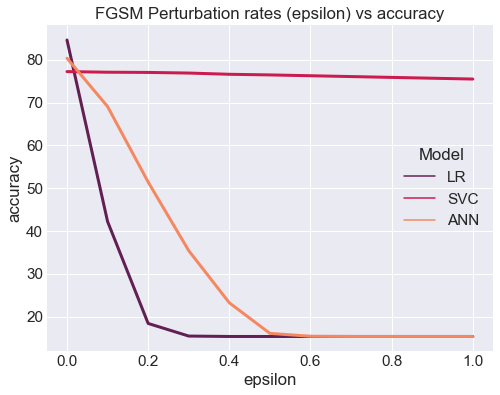

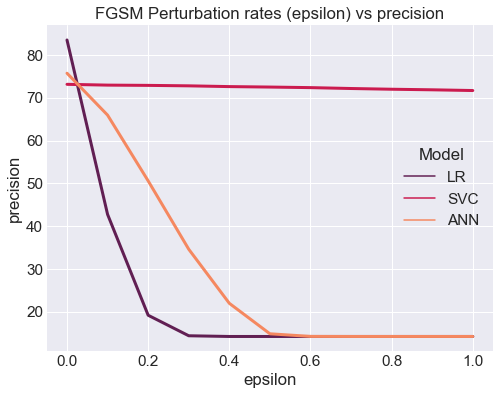

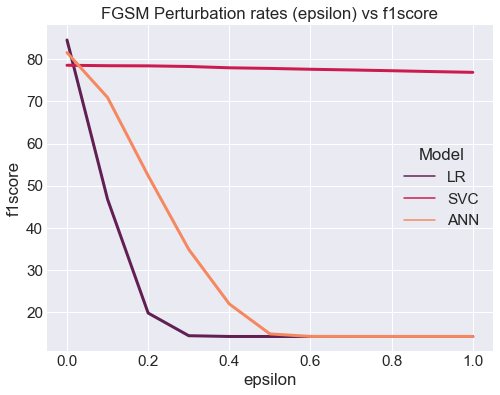

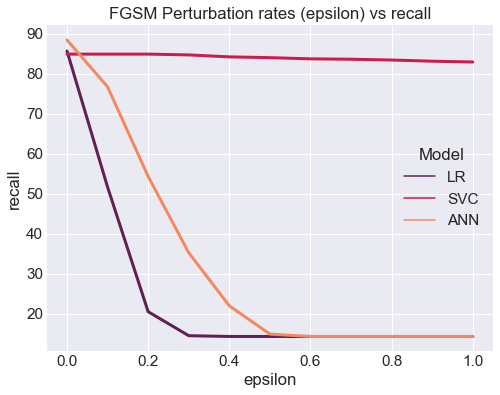

In [53]:
metric=['accuracy','precision','f1score', 'recall']
for i in metric:
    plt.figure(figsize = (8, 6))
    sns.color_palette("Spectral", as_cmap=True)
    sns.axes_style("whitegrid")
    sns.lineplot(data = fgsm_res,
               x = 'epsilon', 
               y = i, 
               hue = 'Model', 
               palette = "rocket",
                linewidth = 3)
    plt.title("FGSM Perturbation rates (epsilon) vs " + i)

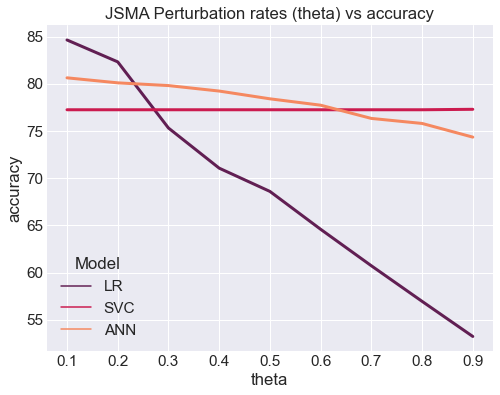

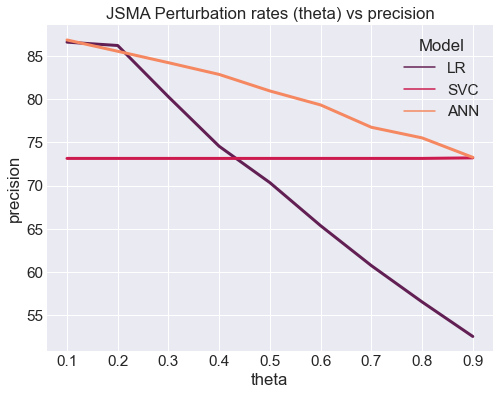

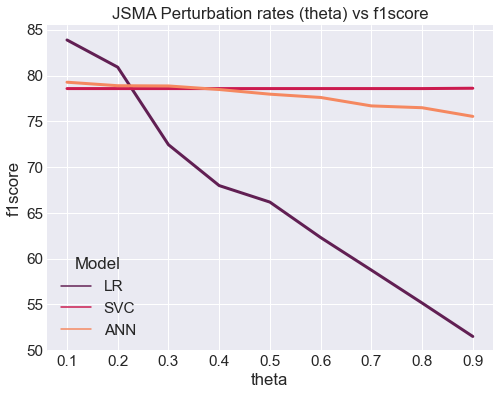

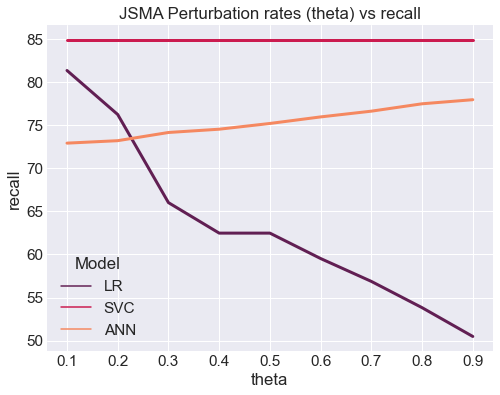

In [54]:
metric=['accuracy','precision','f1score', 'recall']
for i in metric:
    plt.figure(figsize = (8, 6))
    sns.color_palette("Spectral", as_cmap=True)
    sns.lineplot(data = jsma_res,
               x = 'theta', 
               y = i, 
               hue = 'Model', 
               palette = "rocket",
                linewidth = 3)
    plt.title("JSMA Perturbation rates (theta) vs " + i)

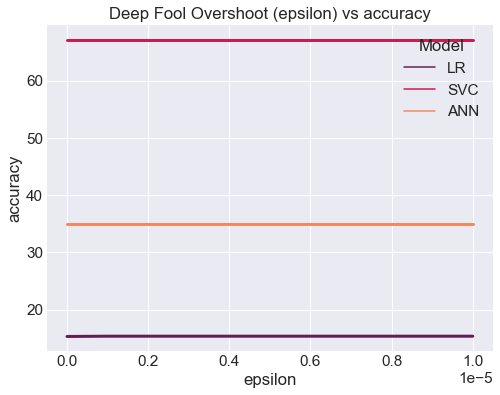

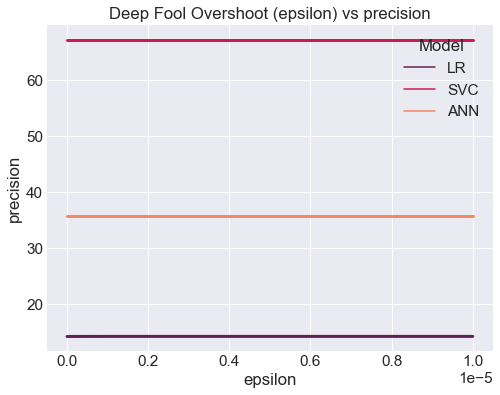

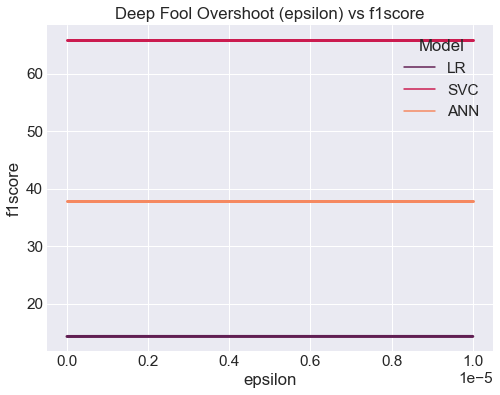

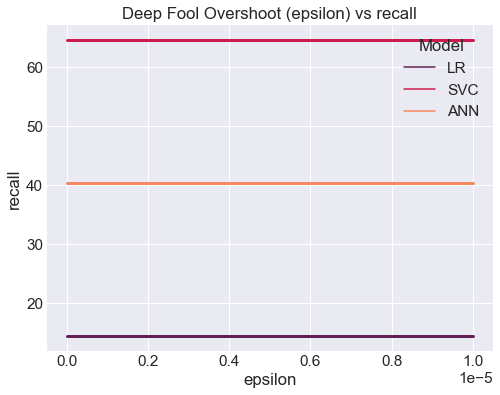

In [55]:
metric=['accuracy','precision','f1score', 'recall']
for i in metric:
    plt.figure(figsize = (8, 6))
    sns.color_palette("Spectral", as_cmap=True)
    sns.lineplot(data = deepfool_res,
               x = 'epsilon', 
               y = i, 
               hue = 'Model', 
               palette = "rocket",
                linewidth = 3)
    plt.title("Deep Fool Overshoot (epsilon) vs " + i)

In [56]:
#save as data
deepfool_res.to_csv('deepfool_results', index=False)
fgsm_res.to_csv('fgsm_results', index=False)
jsma_res.to_csv('jsma_results', index=False)